In [76]:
import os
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from glob import glob

sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")
from scripts.diffusion.models.Unet_base import Unet
from scripts.diffusion.DDPM import DDPM, TimestepSampler
from scripts.maploader.datamodules import DataModule
from scripts.utils.params import set_params
from scripts.utils.run_utils import setup_trainer
from scripts.utils.test_utils import read_yaml, run_reverse_test

In [2]:
pl.seed_everything(1234)

[rank: 0] Global seed set to 1234


1234

# Data Loading

In [12]:
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
ckpt_dir = f"{base_dir}/ckpt_logs/n100_s512_o8_b24_dTrue_concat_batch_silu_aFalse_mTrue_cosine_t2000/version_0"
params = read_yaml(f"{ckpt_dir}/hparams.yaml")
ckpt_path = sorted(glob(f"{ckpt_dir}/checkpoints/*.ckpt"), key=lambda x: float(x.split('=')[-1].rsplit('.', 1)[0]))[-1]

In [16]:
params = set_params(
        n_maps=1,
        nside=512,
        order=8,
        batch_size=8,
        difference=True,
        conditioning="concat",
        norm_type="batch",
        act_type="silu",
        use_attn=False,
        mask=True,
        scheduler="cosine",
        timesteps=2000,
        log_name="test",
        )

In [17]:
pl.seed_everything(1234)
### get training data
dm = DataModule(**params['data'])
dm.setup()

[rank: 0] Global seed set to 1234


loading 1 maps in the directory.
LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc128.  Number of maps: 1
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc256.  Number of maps: 1
data divided into 768 patches.
train:validation:test = 614:76:78, batch_size: 8


In [21]:
#get sampler type
sampler = TimestepSampler(timesteps=params['diffusion']['timesteps'])
#get model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
unet = Unet(params['data']["nside"], params['data']["order"], **params['architecture'])
model = DDPM(unet, sampler, **params['diffusion']).to(device)

sampler type: uniform, timesteps: 2000
We are using Adam with lr = 0.0001, gamma = 0.9999
We are using mask with gaussian noise
The schedule is cosine with s = 0.015


In [46]:
tmp_cond = torch.from_numpy(np.vstack([dm.dataset[idx][0].unsqueeze(0) for idx in range(12)])).to(device)

In [47]:
tmp_cond.shape

torch.Size([12, 4096, 1])

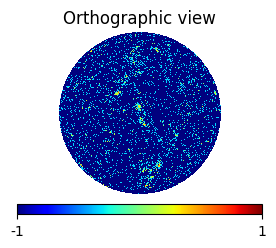

In [50]:
sample = np.hstack(tmp_cond[:,:,0].detach().cpu().numpy())
fig = plt.figure(figsize=(10, 4))
hp.orthview(np.hstack([sample for i in range(4)]),  nest=True, cmap='jet', min=-1, max=1, half_sky=True, sub=(2, 2, 1))

In [72]:
start_step = int(params["diffusion"]["timesteps"]*3/4) 
stats, imgs = run_reverse_test(model.model, model.diffusion, tmp_cond, start_step, device, threshold=np.nan)

step 1475, mean: 0.004, var: 1.084
step 1450, mean: 0.004, var: 1.174
step 1425, mean: 0.005, var: 1.269
step 1400, mean: 0.006, var: 1.370
step 1375, mean: 0.006, var: 1.473
step 1350, mean: 0.007, var: 1.577
step 1325, mean: 0.007, var: 1.686
step 1300, mean: 0.008, var: 1.794
step 1275, mean: 0.009, var: 1.905
step 1250, mean: 0.010, var: 2.019
step 1225, mean: 0.010, var: 2.136
step 1200, mean: 0.011, var: 2.258
step 1175, mean: 0.012, var: 2.382
step 1150, mean: 0.013, var: 2.509
step 1125, mean: 0.013, var: 2.637
step 1100, mean: 0.014, var: 2.767
step 1075, mean: 0.014, var: 2.899
step 1050, mean: 0.015, var: 3.031
step 1025, mean: 0.015, var: 3.165
step 1000, mean: 0.015, var: 3.298
step 975, mean: 0.016, var: 3.432
step 950, mean: 0.016, var: 3.566
step 925, mean: 0.016, var: 3.700
step 900, mean: 0.016, var: 3.833
step 875, mean: 0.017, var: 3.967
step 850, mean: 0.017, var: 4.101
step 825, mean: 0.017, var: 4.235
step 800, mean: 0.017, var: 4.367
step 775, mean: 0.018, var: 

In [68]:
imgs[-1].shape

(12, 4096, 1)

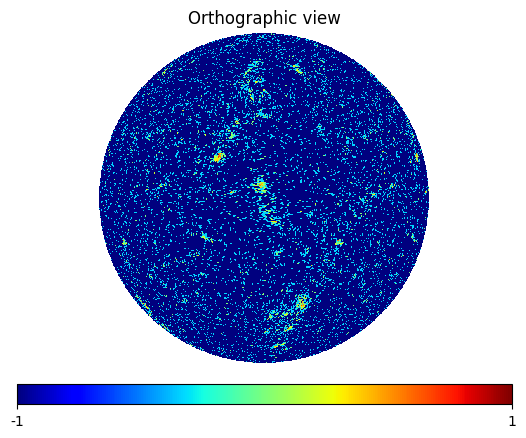

In [75]:
sample = np.hstack(tmp_cond[:,:,0].detach().cpu().numpy())
fig = plt.figure(figsize=(10, 4))
hp.orthview(np.hstack([sample for i in range(4)]),  nest=True, cmap='jet', min=-1, max=1, half_sky=True, sub=(1, 1, 1))

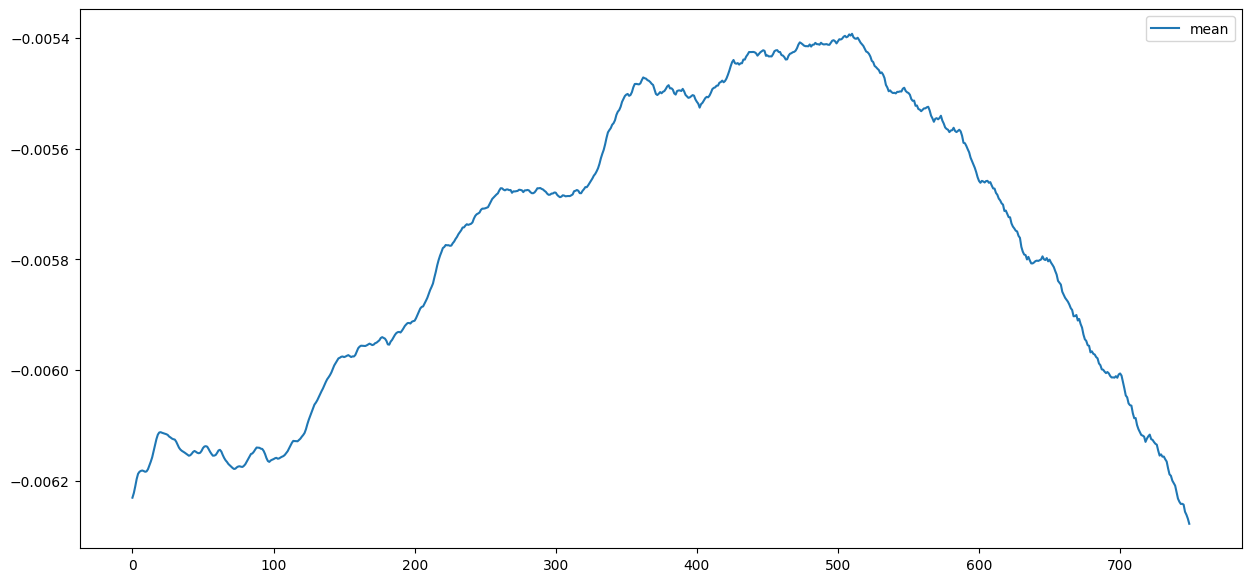

In [66]:
fig = plt.figure(figsize=(15, 7))
plt.plot(stats["mean"].cpu().numpy(), label="mean")
#plt.plot(stats["var"].cpu().numpy(), label="var")
plt.legend()
plt.show()

# Visualization

In [10]:
ckpt_name = "HR_smoothed_concat_cosine_True_8"

sample1 = np.load(f"/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/{ckpt_name}/patch_1/step_000.npy")
sample2 = np.load(f"/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/{ckpt_name}/patch_2/step_000.npy")
#sample3 = np.load(f"/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/HR_sigmoid_concat_linear_True_8/patch_3/step_000.npy")
#sample4 = np.load(f"/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/HR_sigmoid_concat_linear_True_8/patch_4/step_000.npy")

<Figure size 1000x400 with 0 Axes>

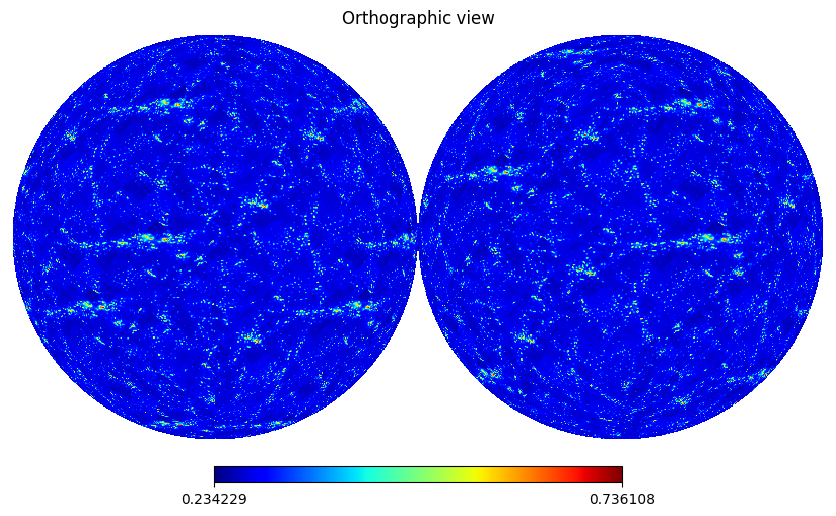

In [26]:
fig = plt.figure(figsize=(10, 4))
hp.orthview(np.hstack([np.hstack(sample1[:,:,0]) for i in range(16)]), 
                       nest=True, cmap='jet')

<Figure size 1000x400 with 0 Axes>

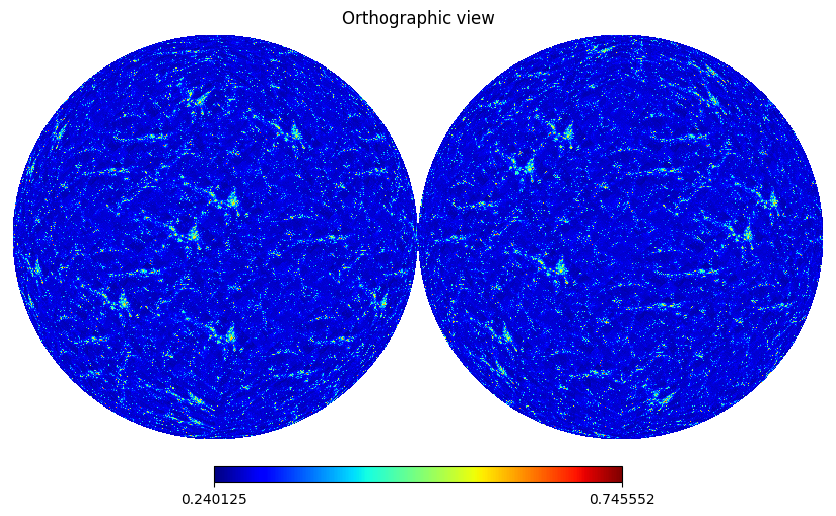

In [21]:
fig = plt.figure(figsize=(10, 4))
hp.orthview(np.hstack([np.hstack([np.hstack(sample1[:,:,0]), np.hstack(sample2[:,:,0])])for i in range(32)]), 
                       nest=True, cmap='jet')

<Figure size 1000x400 with 0 Axes>

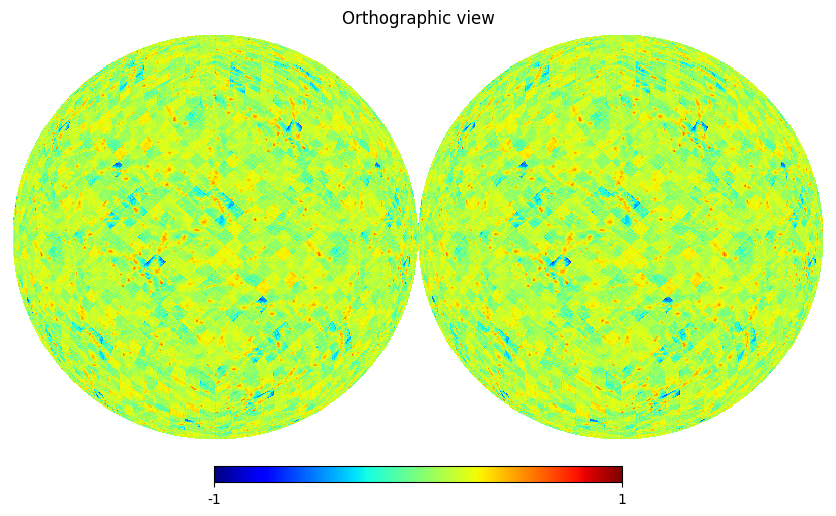

In [44]:
fig = plt.figure(figsize=(10, 4))
hp.orthview(np.hstack([np.hstack([np.hstack(sample1[:,:,0]), np.hstack(sample2[:,:,0]), np.hstack(sample3[:,:,0]), np.hstack(sample4[:,:,0])])for i in range(12)]), 
                       nest=True, cmap='jet', min=-1, max=1)

In [8]:
def read_maps(map_dir, diffsteps=100, batch_size=4):
    maps = sorted(glob(map_dir + "/patch_*/step_*.npy"), key=lambda x: (int(x.split("/")[-1].split(".")[0].split("_")[-1]), int(x.split("/")[-1].split("_")[2]), ))
    map_diffused = []
    for i in range(diffsteps):
        map_steps = []
        for j in range(batch_size):
            #print("Current map: {}".format(maps[i*batch_size+j]))
            map_steps.append(np.load(maps[i*batch_size+j]))
        map_steps = np.array(map_steps)
        map_steps = np.hstack(map_steps)
        map_diffused.append(map_steps)
    map_diffused = np.array(map_diffused)
    return map_diffused

In [71]:
map_dir = f"{base_dir}/results/imgs/diffusion/{params['train']['log_name']}"

maps = sorted(glob(map_dir + "/patch_*/step_*.npy"), key=lambda x: (int(x.split("/")[-1].split(".")[0].split("_")[-1]), int(x.split("/")[-2].split("_")[-1]), ))

In [81]:
tmp_maps = np.hstack(torch.Tensor([np.hstack(np.load(_map)[:,:,0]) for _map in maps[:16]]))

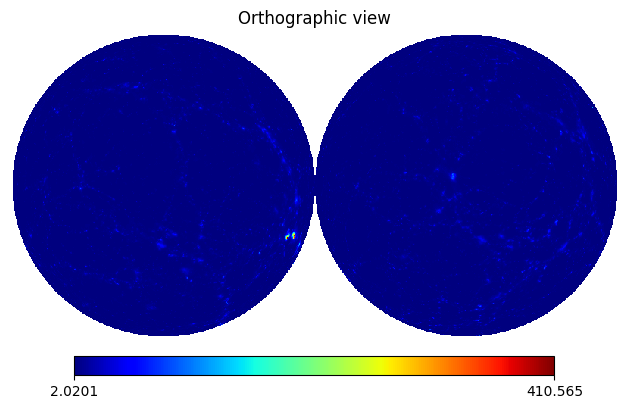

In [83]:
gen_hp = transform_lr.inverse_transform(torch.Tensor(tmp_maps + np.hstack(data_condition[:,:,0].cpu().numpy()))).cpu().numpy()
fig = plt.figure(figsize=(10, 4))
hp.orthview(gen_hp, nest=True, cmap='jet', fig=fig)

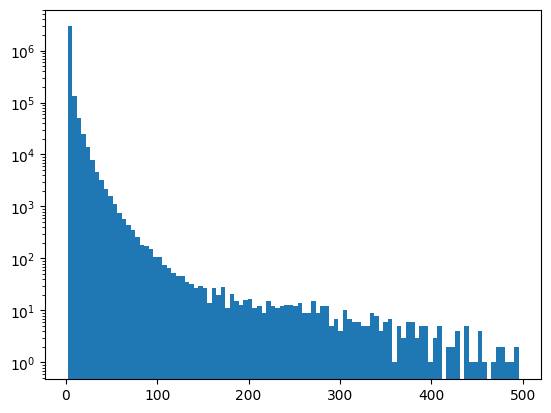

In [92]:
plt.hist(gen_hp.flatten(), bins=100)
plt.yscale("log")
plt.show()

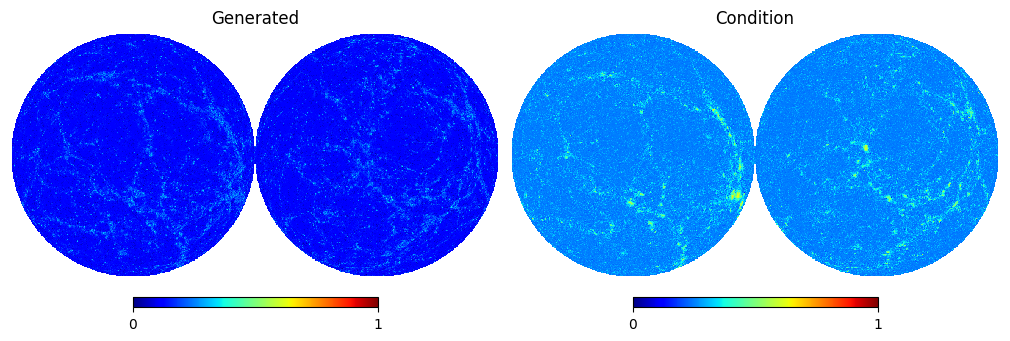

In [87]:
gen_map = np.hstack(tmp_maps)
cond_map = np.hstack(data_condition[:,:,0].cpu().numpy())

fig = plt.figure(figsize=(10, 4))
hp.orthview(gen_map, nest=True, cmap='jet', fig=fig, sub=(1, 2, 1), title="Generated", min=0, max=1)  
hp.orthview(cond_map, nest=True, cmap='jet', fig=fig, sub=(1, 2, 2), title="Condition", min=0, max=1)

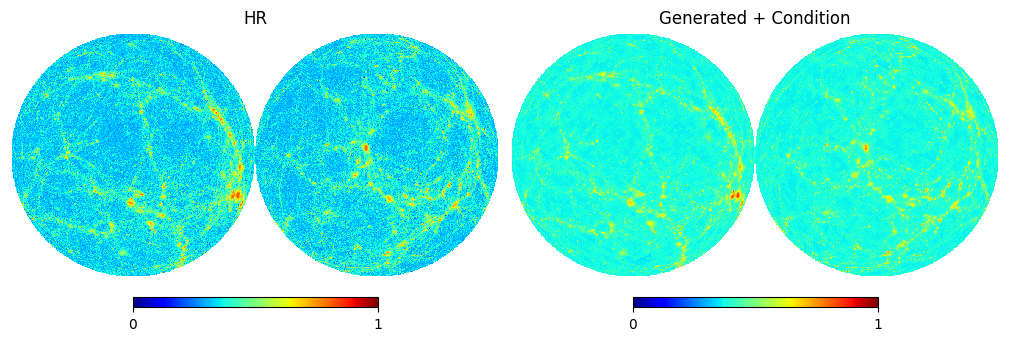

In [90]:
hr_map = np.hstack(data_val[:,:,0].cpu().numpy())

fig = plt.figure(figsize=(10, 4))
hp.orthview(hr_map, nest=True, cmap='jet', fig=fig, sub=(1, 2, 1), title="HR", min=0, max=1)
hp.orthview(gen_map + cond_map, nest=True, cmap='jet', fig=fig, sub=(1, 2, 2), title="Generated + Condition", min=0, max=1)

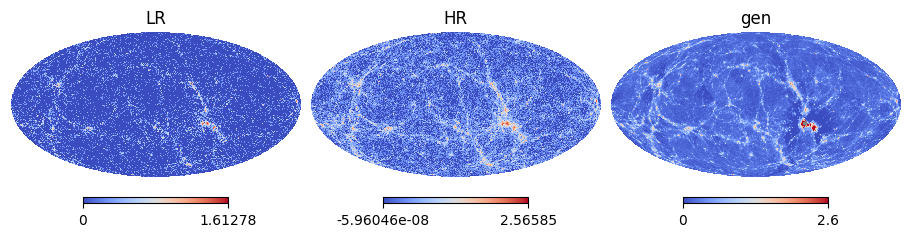

In [28]:
fig = plt.figure(figsize=(9, 4))
hp.mollview(lr_hp, nest=True,  cmap="coolwarm", sub=(1,3, 1), title="LR")
hp.mollview(lr_hp + diff_hp, nest=True, cmap="coolwarm", sub=(1,3, 2), title="HR")
hp.mollview(lr_hp + gen_map, nest=True, cmap="coolwarm", sub=(1,3, 3), title="gen", min=0, max=2.6)

In [77]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

In [78]:
def plot_ps(cls, fig, ax):
    if len(cls) == 2:
        labels = ["input", "target"]
    elif len(cls) == 3:
        labels = ["input", "target", "output"]
    elif len(cls) == 4:
        labels = ["input", "target", "output", "diff"]
    else:
        raise ValueError("cls must be 2 or 3 or 4 length")
    ell = np.arange(len(cls[0]))
    for cl, label in zip(cls, labels):
        ax.plot(ell*(ell+1)*cl/(2*np.pi), label=label, alpha=0.7)
    ax.set_xlabel("l", fontsize=12)
    ax.set_ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=12)
    ax.set_yscale("log")
    ax.legend(loc="lower right", fontsize=12)
    return fig, ax

In [79]:
def plot_maps_png(i, sr_hp, lr_hp, hr_hp, png_dir, tmp_min, tmp_max, verbose=False):
    fig = plt.figure(figsize=(12,4))
    hp.mollview(sr_hp, nest=True, fig=fig, title=f'Generated Diff step_{str((99-i)*10).zfill(3)}+ LR', sub=(1,3,1), min=tmp_min, max=tmp_max)
    hp.mollview(hr_hp, nest=True, fig=fig, title='HR', sub=(1,3,2), min=tmp_min, max=tmp_max)
    hp.mollview(lr_hp, nest=True, fig=fig, title='LR', sub=(1,3,3), min=tmp_min, max=tmp_max)
    if verbose:
        plt.show()
    else:
        fig.savefig(png_dir + f"/step_{(99-i)*10}.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

def plot_ps_png(i, cls, ps_dir, lmax, verbose=False):
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    fig, ax = plot_ps(cls, fig, ax)
    ax.set_title(f"step_{str((99-i)*10).zfill(3)}")
    if verbose:
        plt.show()
    else:
        fig.savefig(ps_dir + f"/step_{(99-i)*10}_ps.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

In [80]:
png_dir = f"{base_dir}/results/imgs/diffusion/{params['train']['log_name']}/png"
os.makedirs(png_dir, exist_ok=True)

for i in range(120):
    tmp_maps = torch.Tensor([np.hstack(np.load(_map)[:,:,0]) for _map in maps[16*i:16*(i+1)]])
    gen_map = np.hstack(tmp_maps)
    fig = plt.figure(figsize=(7,4))
    hp.mollview(gen_map, nest=True, cmap='jet', fig=fig, min=-1, max=1)
    fig.savefig(png_dir + f"/step_{i*10}.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

KeyboardInterrupt: 

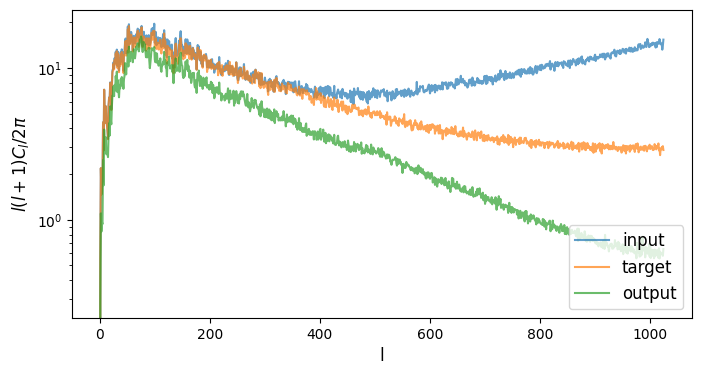

In [85]:
lmax =int(512 * 2)

input_cl = hp.sphtfunc.anafast(t2hpr(np.hstack(lr[:,:,0].cpu().numpy())), lmax=lmax) * 8**2
target_cl = hp.sphtfunc.anafast(t2hpr(np.hstack(hr[:,:,0].cpu().numpy())), lmax=lmax)
output_cl =hp.sphtfunc.anafast(t2hpr(gen_hp), lmax=lmax) 
cls = [input_cl, target_cl, output_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
fig, ax = plot_ps(cls, fig, ax)

In [39]:
inverse_transform_lr.inverse_transform(data_condition).max()

tensor(55.4344)

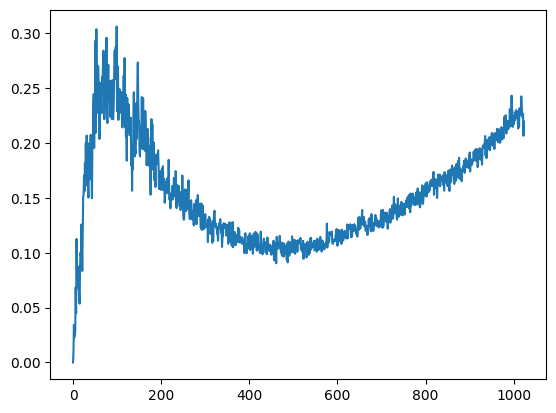

In [46]:
input_cl = hp.sphtfunc.anafast(t2hpr(np.hstack(inverse_transform_lr.inverse_transform(data_condition)[:,:,0].detach().cpu().numpy())), lmax=512 * 2 -1)
ell = np.arange(len(input_cl))
plt.plot(ell, ell*(ell+1)*input_cl/(2*np.pi))
#plt.yscale("log")

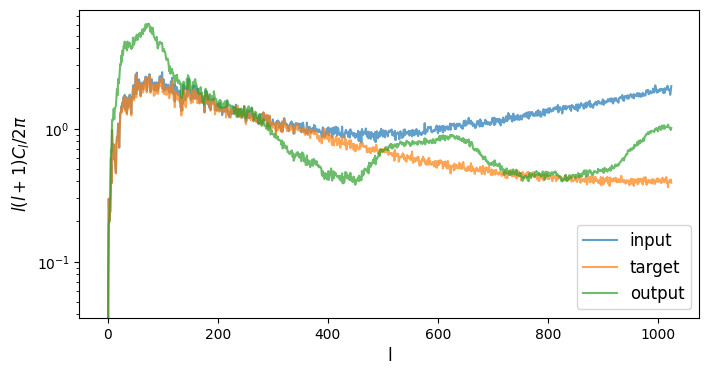

In [49]:
lmax =int(512 * 2)
input_cl = hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(lr_hp)-1), lmax=lmax) * 8**2
target_cl = hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(lr_hp + diff_hp)-1), lmax=lmax)
output_cl =hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(lr_hp + gen_map)-1), lmax=lmax)
cls = [input_cl, target_cl, output_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
fig, ax = plot_ps(cls, fig, ax)

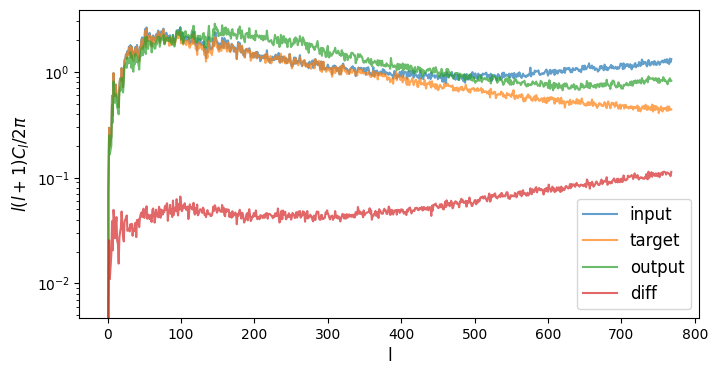

In [169]:
output_cl =hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp)-1), lmax=lmax)
diff_cl = hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp - lr_hp)-1), lmax=lmax)
cls = [input_cl, target_cl, output_cl, diff_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
fig, ax = plot_ps(cls, fig, ax)

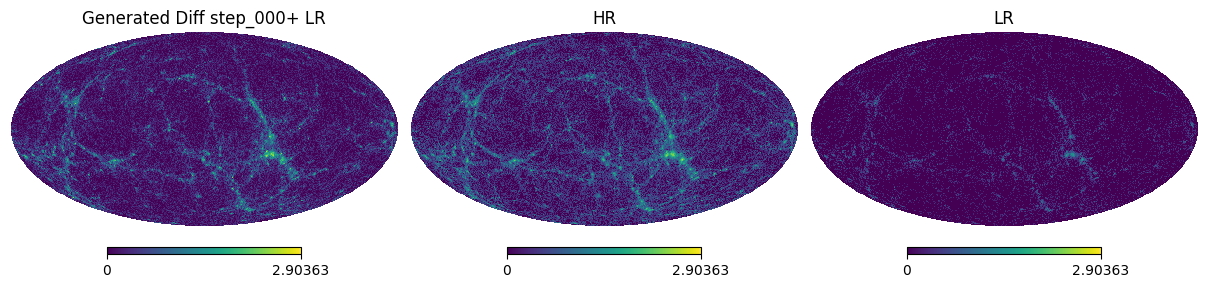

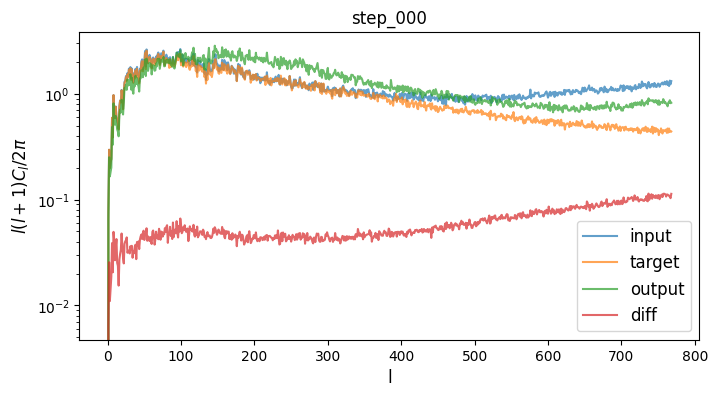

In [170]:
plot_maps_png(99, sr_hp, lr_hp, hr_hp, map_dir + "/png", range_min_hr, range_max_hr, True)
plot_ps_png(99, cls, map_dir + "/ps", 3*nside, True)